## ch3 Machine learning : multi-step2 (direct)

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.09.09 </div>
<div style="text-align: right\"> Last update: 2022.09.09</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [20]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

In [3]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [4]:
def load_dexcom_data(path, sampling_time='5min'):
    df = pd.read_csv(path)
    df = df[df['타임스탬프(YYYY-MM-DDThh:mm:ss)'].notnull()]
    df = df.iloc[:,[1, 7]]
    df.columns = ['timestamp', 'glucose']
    df = df.reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round(sampling_time)
    df = df.dropna()
    idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq=sampling_time)
    df = df.set_index('timestamp').reindex(idx, fill_value=np.nan).reset_index().rename(columns = {'index': 'timestamp'})
    
    return df

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, col_name = 'glucose', dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [(col_name+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [col_name+'(t)']
        else:
            names += [(col_name+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 1. 데이터 셋 만들기

In [10]:
path = 'dexcom_sample.csv'
cgm = load_dexcom_data(path)
cgm['glucose_diff'] = cgm['glucose'].diff()
cgm = cgm.dropna()
df_sv = series_to_supervised(cgm[['glucose']], n_in=4, n_out = 4, dropnan = False)
diff = series_to_supervised(cgm[['glucose_diff']], n_in=4, n_out = 4, 
                             col_name='diff', dropnan = False)

df_sv[['diff(t-4)', 'diff(t-3)', 'diff(t-2)', 'diff(t-1)', 'diff(t)']]=\
diff[['diff(t-4)', 'diff(t-3)', 'diff(t-2)', 'diff(t-1)', 'diff(t)']]

df_sv['timestamp'] = cgm['timestamp']
df_sv = df_sv[['timestamp', 'diff(t-4)', 'diff(t-3)', 'diff(t-2)', 'diff(t-1)', 
               'diff(t)','glucose(t-4)', 'glucose(t-3)', 'glucose(t-2)', 
               'glucose(t-1)', 'glucose(t)', 
               'glucose(t+1)', 'glucose(t+2)', 'glucose(t+3)']]

df_sv['glucose(t+4)'] = df_sv['glucose(t+3)'].shift(-1)
df_sv['glucose(t+5)'] = df_sv['glucose(t+4)'].shift(-1)

df_sv = df_sv.dropna().reset_index(drop = True)
df_sv = df_sv.set_index('timestamp').loc[:'2022-06-10 21:15'].reset_index(drop=False)

In [11]:
df_sv.head()

,timestamp,diff(t-4),diff(t-3),diff(t-2),diff(t-1),diff(t),glucose(t-4),glucose(t-3),glucose(t-2),glucose(t-1),glucose(t),glucose(t+1),glucose(t+2),glucose(t+3),glucose(t+4),glucose(t+5)
0,2022-06-01 07:20:00,3.0,3.0,3.0,1.0,0.0,122.0,125.0,128.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0
1,2022-06-01 07:25:00,3.0,3.0,1.0,0.0,1.0,125.0,128.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0
2,2022-06-01 07:30:00,3.0,1.0,0.0,1.0,-2.0,128.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0,137.0
3,2022-06-01 07:35:00,1.0,0.0,1.0,-2.0,-1.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0,137.0,127.0
4,2022-06-01 07:40:00,0.0,1.0,-2.0,-1.0,-3.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0,137.0,127.0,117.0


In [12]:
train_index = 2735

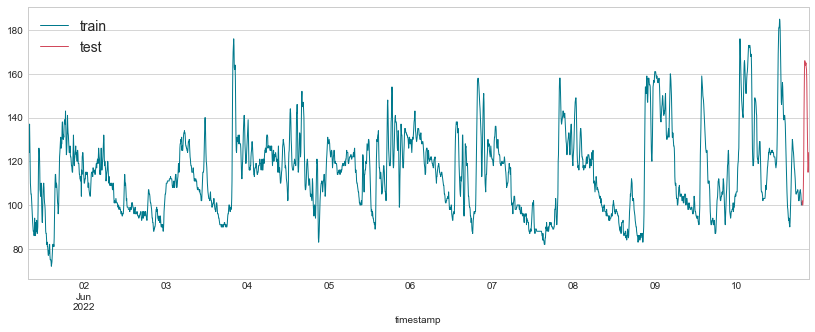

In [13]:
fig, ax = plt.subplots(figsize = (14, 5))
df_sv[:train_index].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
                                                       linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, label = 'test')
plt.legend(fontsize = 14)
plt.show()

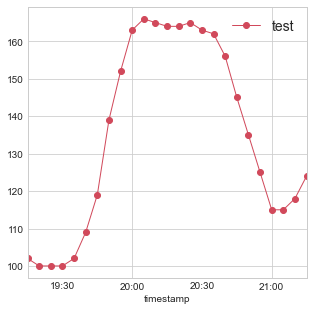

In [14]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')
plt.legend(fontsize = 14)
plt.show()

In [15]:
X_train = df_sv.iloc[:train_index, 1:11]
y_train = df_sv.iloc[:train_index, 11:]

X_test = df_sv.iloc[train_index:, 1:11].reset_index(drop = True)
y_test = df_sv.iloc[train_index:, 11:].reset_index(drop = True)

In [16]:
print(X_train.shape)
print(X_test.shape)

(2735, 10)
(25, 10)


In [17]:
X_train.head()

,diff(t-4),diff(t-3),diff(t-2),diff(t-1),diff(t),glucose(t-4),glucose(t-3),glucose(t-2),glucose(t-1),glucose(t)
0,3.0,3.0,3.0,1.0,0.0,122.0,125.0,128.0,129.0,129.0
1,3.0,3.0,1.0,0.0,1.0,125.0,128.0,129.0,129.0,130.0
2,3.0,1.0,0.0,1.0,-2.0,128.0,129.0,129.0,130.0,128.0
3,1.0,0.0,1.0,-2.0,-1.0,129.0,129.0,130.0,128.0,127.0
4,0.0,1.0,-2.0,-1.0,-3.0,129.0,130.0,128.0,127.0,124.0


In [18]:
y_train.head()

,glucose(t+1),glucose(t+2),glucose(t+3),glucose(t+4),glucose(t+5)
0,130.0,128.0,127.0,124.0,124.0
1,128.0,127.0,124.0,124.0,130.0
2,127.0,124.0,124.0,130.0,137.0
3,124.0,124.0,130.0,137.0,127.0
4,124.0,130.0,137.0,127.0,117.0


### 2. 머신러닝 모델 학습

In [21]:
model = MultiOutputRegressor(XGBRegressor(n_estimators = 1000, learning_rate = 0.05))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [22]:
y_pred

array([[102.63825 , 103.037285, 101.07857 , 104.01554 , 102.89922 ],
       [ 97.19408 ,  98.16224 ,  98.22027 , 101.09115 , 100.73226 ],
       [ 99.786125, 101.26943 , 104.015076, 101.49327 , 101.24505 ],
       [100.211945, 100.56381 , 100.22047 ,  99.83994 , 100.21078 ],
       [103.31671 , 104.199394, 103.70415 , 103.33743 , 105.12857 ],
       [117.55769 , 120.506294, 123.05059 , 129.08804 , 130.40166 ],
       [125.921974, 134.62483 , 136.4105  , 138.02895 , 147.77855 ],
       [151.63914 , 163.72208 , 160.97403 , 163.54333 , 156.73471 ],
       [162.8328  , 169.10056 , 170.56621 , 169.05096 , 157.72617 ],
       [168.21507 , 168.7992  , 167.68593 , 168.12125 , 161.64325 ],
       [165.57076 , 159.51193 , 161.12833 , 154.83452 , 149.34612 ],
       [163.35463 , 165.56406 , 162.2705  , 157.49838 , 146.61523 ],
       [164.11766 , 162.15073 , 165.57408 , 162.7033  , 153.38837 ],
       [165.4829  , 166.66223 , 167.43906 , 162.88974 , 158.40776 ],
       [165.28625 , 163.44926 , 16

In [25]:
markers = ['X', 'D', 'v', '*', '+']
marker_colors = ['#2ca02c', 'r', 'b', 'c', 'tab:purple', 'tab:orange']

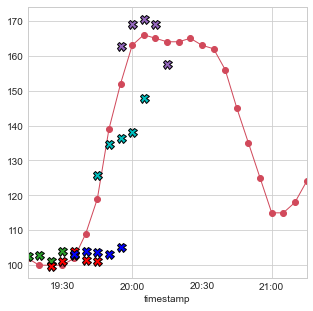

In [27]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')

for i in range(5):  
    pred = y_pred[2*i]#5개 step 예측
    df_sv['pred'] = np.nan
    df_sv.loc[train_index+2*i:train_index+2*i+4, 'pred']= pred
    
    df_sv[train_index:].set_index('timestamp')['pred'].plot(ax = ax, linewidth=0, 
                                                            marker='X', 
                                                       label='Predictions',
                                                       markersize = 9,
                                                       markeredgecolor = 'k',
                                                       color=marker_colors[i])

#plt.legend(fontsize = 14)